# Problem Set 3 CS129.18

The following problem set will revolve around the Enron Emails dataset.
The dataset `data/enron-data/` directory has 6 files. The objective is to build a classifier for whether email is spam or not.


## Requirements


>Spam or Ham?

Using the lessons on Naive Bayes and TF-IDF, and the other resource notebooks, show the following in this Jupyter Notebook.

Write your answers down as Markdown cells or comments in the code.

**Using Enron 1 and 2**

1. How many Spam Emails are there? ( 1 pt )

2. Structure the email data from the 2 directories into 1 dataframe with columns: Status, Subject, Body ( 7 pts )

3. Build a Naive Bayes classifier to classify whether emails are spam or not. ( 3 pts )

4. What is the longest ham email? ( 1 pt )

5. What is the accuracy of your model?( 1 pt )

6. Include the Subject in the analysis of the emails, does the accuracy/performance of the model increase? (7 pts)



-----


Bonus : Answer questions 1-6 using Enron 1,2, and 3. (5 pts)

----

**Submit this file on Moodle on the submission link I will provide. This is due October 18 12nn.**

In [1]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os
import random
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
def store_in_list(rootdir, ham_list, spam_list):
    # Same as before, but this time, read the files, and append them to the ham and spam list
    for directories, subdirs, files in os.walk(rootdir):
        if (os.path.split(directories)[1]  == 'ham'):
            for filename in files:      
                with open(os.path.join(directories, filename), encoding="latin-1") as f:
                    data = f.read()
                    ham_list.append(data)

        if (os.path.split(directories)[1]  == 'spam'):
            for filename in files:
                with open(os.path.join(directories, filename), encoding="latin-1") as f:
                    data = f.read()
                    spam_list.append(data)
                    
    return

In [3]:
rootdir_1 = "data/enron-data/enron1"
rootdir_2 = "data/enron-data/enron2"

# Loop through all the directories, sub directories and files in the above folder, and print them.
for directories, subdirs, files in os.walk(rootdir_1):
    print(directories, subdirs, len(files))
    
for directories, subdirs, files in os.walk(rootdir_2):
    print(directories, subdirs, len(files))

data/enron-data/enron1 ['spam', 'ham'] 2
data/enron-data/enron1/spam [] 1499
data/enron-data/enron1/ham [] 3672
data/enron-data/enron2 ['spam', 'ham'] 1
data/enron-data/enron2/spam [] 1494
data/enron-data/enron2/ham [] 4361


In [4]:
ham_list = []
spam_list = []

# Store data into ham and spam lists
store_in_list(rootdir_1, ham_list, spam_list)
store_in_list(rootdir_2, ham_list, spam_list)

In [5]:
print(ham_list[0])
print(spam_list[0])

Subject: ena sales on hpl
just to update you on this project ' s status :
based on a new report that scott mills ran for me from sitara , i have come up
with the following counterparties as the ones to which ena is selling gas off
of hpl ' s pipe .
altrade transaction , l . l . c . gulf gas utilities company
brazoria , city of panther pipeline , inc .
central illinois light company praxair , inc .
central power and light company reliant energy - entex
ces - equistar chemicals , lp reliant energy - hl & p
corpus christi gas marketing , lp southern union company
d & h gas company , inc . texas utilities fuel company
duke energy field services , inc . txu gas distribution
entex gas marketing company union carbide corporation
equistar chemicals , lp unit gas transmission company inc .
since i ' m not sure exactly what gets entered into sitara , pat clynes
suggested that i check with daren farmer to make sure that i ' m not missing
something ( which i did below ) . while i am waiting for a 

#### 1. How many Spam Emails are there? ( 1 pt )
---

In [6]:
len(spam_list) # In total, there are 2993 spam emails in Enron 1 and 2

2993

#### 2. Structure the email data from the 2 directories into 1 dataframe with columns: Status, Subject, Body ( 7 pts )
---

In [7]:
def subject_thread(email):
    count = 0

    for line in email:
        line = line.lower()
        
        # Check if line contains the keyword 'Subject:'
        if 'subject: ' in line:
            subject = line[len('subject: '):]
            count += 1
        elif 'subject : ' in line and subject in line:
            count += 1
         
    # If there are multiple instances of subject, email has a thread
    if count > 1:
        return subject, True
    else:
        return subject, False

In [8]:
def get_body(email):
    body = ""
    for line in email:
        line = line.lower()
        
        # Check if line does not contain keyword 'Subject:'
        if (('subject:' or 'subject :' or 'to :' or 'from :' or 'cc :') not in line):
            body = f'{body} {line}'
    return body   

In [9]:
def sender_recipient_cc(email):
    sender = 'None'
    recipient = 'None'
    cc = 'None'
    
    for line in email:
        line = line.lower()
        
        # Check if line does not contain keyword ':'
        if 'to :' in line:
            recipient = line[len('to :'):] 
        elif 'from :' in line:
            sender = line[len('from :'):]
        elif 'cc :' in line:
            cc = line[len('cc :'):]
            
    return sender, recipient, cc

In [10]:
def split_list(email_list, status, data_list):
    for email in email_list:
        # Split email by line
        email = email.splitlines()

        # Get the subject and the ~body of the email
        subject, isThread = subject_thread(email)
        body = get_body(email)
        sender, recipient, cc = sender_recipient_cc(email)
        
        # Append to list acting as row
        row = [status, sender, recipient, cc, subject, body, isThread]
        
        # Append to list that will be converted to a df
        data_list.append(row)
        
    return

In [11]:
data_list = []

split_list(ham_list, 'ham', data_list)
split_list(spam_list, 'spam', data_list)

In [12]:
df = pd.DataFrame(data_list, columns=['Status','Sender','Recipient','CC','Subject','Body','isThread'])
df

,Status,Sender,Recipient,CC,Subject,Body,isThread
0,ham,None,"daren j farmer / hou / ect @ ect , mary m smi...",,ena sales on hpl,just to update you on this project ' s status...,True
1,ham,None,None,None,98 - 6736 & 98 - 9638 for 1997 ( ua 4 issues ),the above referenced meters need to be placed...,False
2,ham,None,None,None,"hpl nominations for december 28 , 1999",( see attached file : hpll 228 . xls ) - hpll...,False
3,ham,robert cotten 06 / 29 / 2000 03 : 35 pm,daren j farmer / hou / ect @ ect,,revised nom - kcs resources,"daren , it ' s in . bob - - - - - - - - - - -...",True
4,ham,None,robert cotten / hou / ect @ ect,"lisa hesse / hou / ect @ ect , trisha hughes ...",new production - sitara deals needed,"daren , fyi . bob - - - - - - - - - - - - - -...",True
...,...,...,...,...,...,...,...
11021,spam,None,None,None,update account information,"important alert hello sir / madam , founded i...",False
11022,spam,None,None,None,real time leads - no brokers,your name : email address : telephone : compa...,False
11023,spam,None,None,None,save your money buy getting this thing here,you have not tried cialls yet ? than you cann...,False
11024,spam,None,None,None,secretly record all internet activity on any c...,find out who they are chatting / e - mailing ...,False


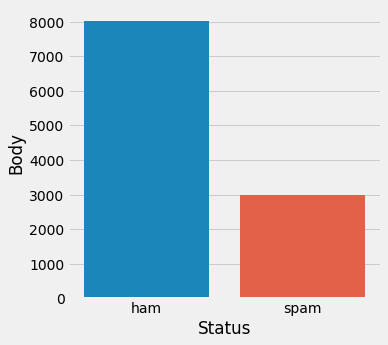

In [13]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(5,5))

df_2 = df.groupby('Status').count()
df_2.reset_index(inplace=True)
sns.barplot(x='Status', y='Body', data=df_2);

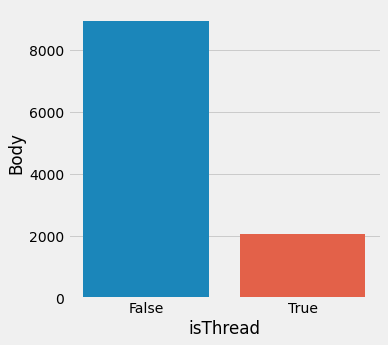

In [14]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(5,5))

df_2 = df.groupby('isThread').count()
df_2.reset_index(inplace=True)
sns.barplot(x='isThread', y='Body', data=df_2);

#### 3. Build a Naive Bayes classifier to classify whether emails are spam or not. ( 3 pts )
---

In [40]:
X = df['Body']
Y = df['Status']

X

0         just to update you on this project ' s status...
1         the above referenced meters need to be placed...
2         ( see attached file : hpll 228 . xls ) - hpll...
3         daren , it ' s in . bob - - - - - - - - - - -...
4         daren , fyi . bob - - - - - - - - - - - - - -...
                               ...                        
11021     important alert hello sir / madam , founded i...
11022     your name : email address : telephone : compa...
11023     you have not tried cialls yet ? than you cann...
11024     find out who they are chatting / e - mailing ...
11025     affordable domain registration for everyone t...
Name: Body, Length: 11026, dtype: object

In [16]:
# Vectorize before splitting
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(X) 

In [17]:
# 80-20 trainining-test split
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.2)

In [18]:
classifier = GaussianNB() # Assumes a Gaussian distribution for whether a message is spam
classifier.fit(train_x.toarray(), train_y)

GaussianNB()

#### 4. What is the longest ham email? ( 1 pt )
---

In [19]:
df_length = df
# Generate a column with length of email body
df_length['BodyLength'] = df_length['Body'].str.len()

In [20]:
# Get all rows where status is ham, then get max BodyLength using idxmax()
df_ham = df_length.loc[(df_length.Status == 'ham'), ['Status','Body','BodyLength']]
df_ham.loc[df_ham.BodyLength.idxmax()]

Status                                                      ham
Body           fyi news articles from indian press . - - - -...
BodyLength                                                43754
Name: 5549, dtype: object

#### 5. What is the accuracy of your model?( 1 pt )
---


In [21]:
# 5 folds for cross-validation
scores = cross_val_score(classifier, test_x.toarray(), test_y, cv=5)
acc = scores.mean()

print("Accuracy: %0.2f percent (+/- %0.2f)" % (acc *100, scores.std()))
scores

Accuracy: 93.11 percent (+/- 0.01)


array([0.94117647, 0.93424036, 0.93197279, 0.92743764, 0.92063492])

In [22]:
# Try classifying sample messages
df['Prediction'] = classifier.predict(vectorizer.transform(df['Body']).toarray())

In [23]:
df[['Status','Prediction','Body']].sample(20)

,Status,Prediction,Body
5847,ham,ham,"duane , i shall be traveling for the rest of ..."
5756,ham,ham,good afternoon sandeep : i sent krishna ' s e...
2976,ham,ham,"> juliann , there is a chance that the unit u..."
9830,spam,spam,thinking of breathing new life into your busi...
3842,ham,ham,"trena , i have received your message . please..."
6225,ham,ham,"john , i shall see christie tomorrow and i sh..."
1708,ham,ham,darren : i have some updates for tenaska iv ....
77,ham,ham,please increase deliveries into eastrans to 3...
1617,ham,ham,darren : please remove the price on the tenas...
10966,spam,spam,your girl is unsatisfied with your potency ? ...


#### 6. Include the Subject in the analysis of the emails, does the accuracy/performance of the model increase? (7 pts)
---

In [24]:
# Concatenate body and subject
df["SubjectBody"] = df["Subject"] + df["Body"]
df.drop(['Body','Subject'], axis = 1)

,Status,Sender,Recipient,CC,isThread,BodyLength,Prediction,SubjectBody
0,ham,None,"daren j farmer / hou / ect @ ect , mary m smi...",,True,2572,ham,ena sales on hpl just to update you on this pr...
1,ham,None,None,None,False,494,ham,98 - 6736 & 98 - 9638 for 1997 ( ua 4 issues )...
2,ham,None,None,None,False,56,ham,"hpl nominations for december 28 , 1999 ( see a..."
3,ham,robert cotten 06 / 29 / 2000 03 : 35 pm,daren j farmer / hou / ect @ ect,,True,494,ham,"revised nom - kcs resources daren , it ' s in ..."
4,ham,None,robert cotten / hou / ect @ ect,"lisa hesse / hou / ect @ ect , trisha hughes ...",True,1346,ham,"new production - sitara deals needed daren , f..."
...,...,...,...,...,...,...,...,...
11021,spam,None,None,None,False,1125,spam,update account information important alert hel...
11022,spam,None,None,None,False,1186,spam,real time leads - no brokers your name : email...
11023,spam,None,None,None,False,385,spam,save your money buy getting this thing here yo...
11024,spam,None,None,None,False,400,spam,secretly record all internet activity on any c...


In [25]:
X = df['SubjectBody']
Y = df['Status']

In [26]:
# Vectorize before splitting
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(X) 

In [27]:
# 80-20 trainining-test split
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.2)

In [28]:
classifier = GaussianNB() # Assumes a Gaussian distribution for whether a message is spam
classifier.fit(train_x.toarray(), train_y)

GaussianNB()

In [29]:
# 5 folds for cross-validation
scores = cross_val_score(classifier, test_x.toarray(), test_y, cv=5)
acc = scores.mean()

print("Accuracy: %0.2f percent (+/- %0.2f)" % (acc *100, scores.std()))
scores

Accuracy: 93.97 percent (+/- 0.01)


array([0.95022624, 0.93197279, 0.93650794, 0.94104308, 0.93877551])

In [30]:
# Try classifying sample messages
df['Prediction'] = classifier.predict(vectorizer.transform(df['SubjectBody']).toarray())

In [31]:
df[['Status','Prediction','SubjectBody']].sample(20)

,Status,Prediction,SubjectBody
6941,ham,ham,"re : meet during cmu visit ? aziz , please , c..."
10284,spam,ham,"how are ya ? hey , how ya been ? long time no ..."
5385,ham,ham,"re : vmi agreements hi vince , mark holsworth ..."
10253,spam,spam,search for the best and cheapest pharmacy onli...
5989,ham,ham,hello all update : preparations for the upcomi...
4068,ham,ham,interview follow up from susan v . gonzalez no...
6265,ham,ham,"re : hello from london zimin , i have a copy o..."
4858,ham,ham,cera conference call : mexican energy in trans...
6157,ham,ham,"abstract shmuel , this is the abstract for my ..."
9680,spam,spam,wait too long and . . . 1147 secretly attract ...


7. Trying to add other columns.
---

In [32]:
df.fillna('None')
df["Concatenated"] = df["Sender"] + df["Recipient"] + df["CC"]+ df["Subject"] + df["Body"]

In [33]:
X = df['Concatenated']
Y = df['Status']

In [34]:
# Vectorize before splitting
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(X) 

In [35]:
# 80-20 trainining-test split
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.2)

In [36]:
classifier = GaussianNB() # Assumes a Gaussian distribution for whether a message is spam
classifier.fit(train_x.toarray(), train_y)

GaussianNB()

In [37]:
# 5 folds for cross-validation
scores = cross_val_score(classifier, test_x.toarray(), test_y, cv=5)
acc = scores.mean()

print("Accuracy: %0.2f percent (+/- %0.2f)" % (acc *100, scores.std()))
scores

Accuracy: 94.74 percent (+/- 0.01)


array([0.9638009 , 0.95464853, 0.95011338, 0.92970522, 0.93877551])

In [38]:
# Try classifying sample messages
df['Prediction'] = classifier.predict(vectorizer.transform(df['Concatenated']).toarray())

In [39]:
df[['Status','Prediction','Concatenated']].sample(20)

,Status,Prediction,Concatenated
3916,ham,ham,Nonere : hi ! - - - - - - - - - - - - - - - - ...
2405,ham,ham,NoneNoneNoneenron / hpl actuals for october 27...
1036,ham,ham,None ami _ chokshi @ enron . com royal _ b _ e...
7752,ham,ham,None vince j kaminski / hou / ect @ ect shirle...
4724,ham,ham,"None fap @ enron clay degiacinto @ enron , dee..."
1428,ham,ham,NoneNoneNonecornhusker i have entered deals in...
8481,spam,spam,"NoneNoneNonevicodin , via - gra are che . ap h..."
8564,spam,spam,NoneNoneNonere : the hstoett lady sucklng huge...
3760,ham,ham,cindy derecskey @ enron on 10 / 25 / 2000 11 ...
9766,spam,spam,"NoneNoneNonelocalized software , all languages..."
